# Tests using benchmark datasets

Here we provide a walkthrough of running the experimental evaluation using real-world datasets, and visualizing the results.

The contents of this notebook are as follows:

- <a href="#guide">Guide to running the experiments</a>
- <a href="#visual">Processing and visualizing results</a>

First we give some details describing how to actually run the tests on your machine. The remainder of the demo aids the user in visualizing the test results after the experiments have actually been run.


___

<a id="guide"></a>
## Guide to running the experiments

A high-level description of the full procedure involved in running these experiments is given in the README file of this repository. We assume the user has already covered sections "<a href="https://github.com/feedbackward/spectral#setup_init">Setup: initial software preparation</a>" and "<a href="https://github.com/feedbackward/spectral#setup_data">Setup: preparing the benchmark data sets</a>" from the main README file. As such, all that remains to be done here is to fill in the details related to experiment parameter settings.

Essentially, the experiments are run by calling `learn_driver.py` with the appropriate options (experimental parameters). Results are stored automatically with path and filename as follows:

```
[results_dir]/[data]/[task]-[model]_[algo]-[trial].[descriptor]
```

Here `results_dir` is the directory for storing results, specified in `setup_results.py`. The `descriptor` depends on the method of evaluation used, all specified in `setup_eval.py`. For example, the 0-1 training loss is `zero_one_train`, and the spectral risk test error under the logistic loss is `logistic_srisk_test`, and so forth. The rest is fairly self-explanatory, though we note that for our experiments, `task` is used to specify the nature of the feedback used by the learning algorithm (discussed further below).

### Glossary of experimental parameters

- `--algo-ancillary`: specifies the underlying learning algorithm to use (e.g., SGD); call these the *ancillary iterates*.
- `--algo-main`: lets us specify an additional procedure to operate on the ancillary iterates (e.g., do nothing or average SGD iterates, etc.); call these the *main iterates*.
- `--batch-size`: size of mini-batch to use.
- `--cdf-size`: amount of ancillary data to be used for CDF estimation.
- `--data`: the name of the data set to be used.
- `--entropy`: used to ensure consistency across methods.
- `--fast`: if this flag is used under the spectral risk, then following the naming in our paper, `fast` will be run instead of `default`.
- `--loss`: the name of the loss function to be used.
- `--model`: the name of the model to be used.
- `--no-srisk`: if this flag is used, then it tells the learning algorithm to treat the losses as-is, rather than use our "srisk" (spectral risk) loss wrappers. This amounts to traditional ERM; if this flag is active, the flag `--fast` has no effect.
- `--num-epochs`: the number of passes to make over the training data.
- `--num-trials`: the number of randomized trials to be run.
- `--step-size`: global step-size coefficient (multiplies the step-size computed internally by algorithms).
- `--task-name`: mostly for clerical purposes, when we want to distinguish results for different setups (typically different settings of the flags `--fast` and `--no-srisk`).


### Detailed parameter settings

The experiments given in our paper (2021/05 arXiv version) are computed using the following experimental parameter settings:

- `--algo-ancillary`: `"SGD"`.
- `--algo-main`: `"Ave"`.
- `--batch-size`: `"8"`
- `--cdf-size`: `"250"`
- `--data`: (see dataset names listed in the paper).
- `--loss`: `"logistic"`.
- `--model`: `"linreg_multi"`.
- `--num-epochs`: `"50"`.
- `--num-trials`: `"10"`.
- `--step-size`: `"1.0"`.
- `--task-name`: `"off"` (uses `--no-srisk` flag only), `"default"` (no flags used), `"fast"` (uses `--fast` flag only).


### Execution

If the shell script `learn_run.sh` has been appropriately modified to reflect any of the above settings, then running the experiments is a one-line operation:

```
(spectral) $ bash learn_run.sh
```

If you would rather not do these all manually, feel free to use our `remote_*.sh` scripts for convenience.

Once the tests have been run, a collection of raw experimental results should be written to disk. The following section covers the tasks of processing and visualizing these results.


___

<a id="visual"></a>
## Processing and visualizing results

In [1]:
## External modules.
from contextlib import ExitStack
import json
from matplotlib import cm
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator
import numpy as np
import os

## Internal modules.
from mml.utils import makedir_safe
from setup_data import dataset_paras
from setup_results import img_dir, results_dir, my_fontsize, my_ext, export_legend


In [2]:
## Parameters to be set by the user.
data = "adult" # specify dataset name
model = "linreg_multi" # specify model name
eval_type = "logistic_srisk" # specify evaluation metric (logistic_srisk, zero_one, etc.)

In [3]:
## Helper function definition.
def agg_fn_all(arr, agg_type):
    if agg_type == "mean":
        return np.mean(arr, axis=0)
    elif agg_type == "sd":
        return np.std(arr, axis=0)
    else:
        raise ValueError

In [4]:
## Automated clerical setup.
eval_train = eval_type+"_train"
eval_test = eval_type+"_test"

## Directory setup.
toread_dir = os.path.join(results_dir, data)
towrite_dir = os.path.join(img_dir)
makedir_safe(towrite_dir)

## Colour setup.
mth_cmap = cm.get_cmap("Set1")
mth_colours = []
for i in range(9):
    mth_colours += [mth_cmap.colors[i]]


In [5]:
## Set how we aggregate over trials.
agg_mean = lambda array: agg_fn_all(arr=array, agg_type="mean")
agg_sd = lambda array: agg_fn_all(arr=array, agg_type="sd")

In [6]:
## A few lines of code to extract all the method names.
all_files = os.listdir(toread_dir)
names_raw = []
for s in all_files:
    split_hyphen = s.split("-")
    split_dot = s.split(".")
    if split_dot[-1] != "json":
        names_raw += ["-".join(split_hyphen[0:-1])]
names_raw = np.array(names_raw)
names_unique = np.unique(names_raw)
print("Unique names found:", names_unique)

Unique names found: ['default-linreg_multi_SGD_Ave' 'fast-linreg_multi_SGD_Ave'
 'off-linreg_multi_SGD_Ave']


In [7]:
to_plot_names = { s: s.split("-")[0] for s in names_unique}
to_plot = [s for s in to_plot_names.keys()]
to_plot_colours = {a: mth_colours[j] for j, a in enumerate(to_plot)}

In [8]:
## Gathering of results.
dict_train = {a: [] for a in to_plot}
dict_test = {a: [] for a in to_plot}

for mth_name in to_plot:
    
    trial = 0
    do_gathering = True
    
    while do_gathering:
        
        toread_train = os.path.join(
            toread_dir, ".".join([mth_name+"-"+str(trial), eval_train])
        )
        toread_test = os.path.join(
            toread_dir, ".".join([mth_name+"-"+str(trial), eval_test])
        )
        
        with ExitStack() as stack:
            
            try:
                f_train = stack.enter_context(open(toread_train, mode="r", encoding="ascii"))
                yvals = np.loadtxt(fname=f_train, dtype=float,
                                   delimiter=",", ndmin=2)
                dict_train[mth_name] += [yvals]
            except FileNotFoundError:
                do_gathering = False
                print("({}) Finished collecting training results.".format(mth_name))
                
            try:
                f_test = stack.enter_context(open(toread_test, mode="r", encoding="ascii"))
                yvals = np.loadtxt(fname=f_test, dtype=float,
                                   delimiter=",", ndmin=2)
                dict_test[mth_name] += [yvals]
            except FileNotFoundError:
                print("({}) Finished collecting test results.".format(mth_name))
        
        ## If the current trial went through, increment to try the next one.
        if do_gathering:
            trial += 1
            
dict_train = {a:np.hstack(dict_train[a]).T for a in dict_train.keys()}
dict_test = {a:np.hstack(dict_test[a]).T for a in dict_test.keys()}

(default-linreg_multi_SGD_Ave) Finished collecting training results.
(default-linreg_multi_SGD_Ave) Finished collecting test results.
(fast-linreg_multi_SGD_Ave) Finished collecting training results.
(fast-linreg_multi_SGD_Ave) Finished collecting test results.
(off-linreg_multi_SGD_Ave) Finished collecting training results.
(off-linreg_multi_SGD_Ave) Finished collecting test results.


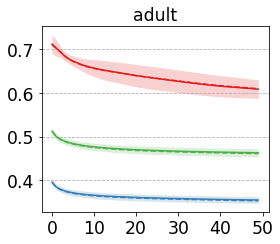

In [9]:
## Visualization of results.

fig, ax = plt.subplots(1, 1, figsize=(4,3.5)) # nice for putting in paper.
#fig, ax = plt.subplots(1, 1, figsize=(7,6)) # nice for viewing in notebook.

for j, mth_name in enumerate(dict_train.keys()):
    yval_array = dict_train[mth_name]
    num_trials, num_epochs = yval_array.shape
    xvals = np.arange(num_epochs)
    yvals = agg_mean(yval_array)
    yvals_err = agg_sd(yval_array)
    ax.plot(xvals, yvals,
            color=to_plot_colours[mth_name],
            label="{} tr".format(to_plot_names[mth_name]),
            ls="--")
    #ax.fill_between(x=xvals, y1=yvals-yvals_err, y2=yvals+yvals_err,
    #                alpha=0.2, color=to_plot_colours[mth_name], lw=0)

for j, mth_name in enumerate(dict_test.keys()):
    yval_array = dict_test[mth_name]
    num_trials, num_epochs = yval_array.shape
    xvals = np.arange(num_epochs)
    yvals = agg_mean(yval_array)
    yvals_err = agg_sd(yval_array)
    ax.plot(xvals, yvals,
            color=to_plot_colours[mth_name],
            label="{} te".format(to_plot_names[mth_name]),
            ls="-")
    ax.fill_between(x=xvals, y1=yvals-yvals_err, y2=yvals+yvals_err,
                    alpha=0.2, color=to_plot_colours[mth_name], lw=0)

ax.tick_params(labelsize=my_fontsize)
#ax.legend(loc=0, ncol=2, fontsize=my_fontsize)
ax.set_title("{}".format(data),
             size=my_fontsize)
fname = os.path.join(towrite_dir, "{}_{}.{}".format(data, eval_type, my_ext))
ax.xaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_major_formatter("{x:.1f}")
#ax.yaxis.set_major_locator(MaxNLocator(5))
ax.yaxis.grid(linestyle="--")
plt.tight_layout()
plt.savefig(fname=fname)
plt.show()

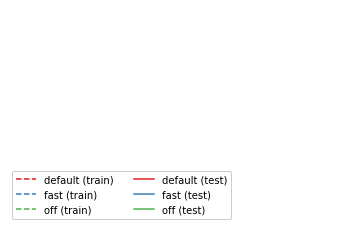

In [10]:
## Legends.

labels = [to_plot_names[a]+" (train)" for a in to_plot] + [to_plot_names[a]+" (test)" for a in to_plot]
colours = [to_plot_colours[a] for a in to_plot] + [to_plot_colours[a] for a in to_plot]
linestyles = ["--"]*len(to_plot_names) + ["-"]*len(to_plot_names)

f = lambda m,c,l: plt.plot([],[],marker=m, color=c, ls=l)[0]
handles = [f(None, colours[i], linestyles[i]) for i in range(len(labels))]
legend = plt.legend(handles, labels, loc=3, ncol=2, framealpha=1, frameon=True)
fname = os.path.join(towrite_dir, "legend.{}".format(my_ext))
export_legend(legend=legend, filename=fname)
plt.show()

___